# CPSC 330 midterm

The University of British Columbia

Instructor: Mike Gelbart

February 13, 2020

Please write your CS ID (a.g. a1b2c) **clearly and legibly** at the left-hand side of the box below:

In this exam we'll be analyzing the [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset from Kaggle. This exam consists of 14 **equally weighted** questions interspersed between parts of the analysis. The exam was printed directly from Jupyter; that is, all the output you see was generated by the code you see, with no "tampering" after-the-fact.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
import graphviz
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
pd.set_option('precision', 2)

The last line (above) tells pandas to print numbers to 2 decimal places (the default is 6 places). This should improve readability for you.

## Preliminaries

Load the data:

In [3]:
df = pd.read_csv('weatherAUS.csv', parse_dates=['Date'])

Split the data by date (you can assume this is a reasonable thing to do):

In [4]:
df_train = df.query('Date <= 20121231')
df_valid = df.query('20130101 <= Date <= 20151231')
df_test  = df.query('Date >= 20160101')

First, I call `df.describe()` to get a sense of some of the features:

In [5]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.00,141871.00,140787.00,81350.00,74377.00,132923.00,140845.00,139563.00,140419.00,138583.00,128179.00,128212.00,88536.00,85099.00,141289.00,139467.00,142193.00
mean,12.19,23.23,2.35,5.47,7.62,39.98,14.00,18.64,68.84,51.48,1017.65,1015.26,4.44,4.50,16.99,21.69,2.36
std,6.40,7.12,8.47,4.19,3.78,13.59,8.89,8.80,19.05,20.80,7.11,7.04,2.89,2.72,6.49,6.94,8.48
min,-8.50,-4.80,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,977.10,0.00,0.00,-7.20,-5.40,0.00
25%,7.60,17.90,0.00,2.60,4.90,31.00,7.00,13.00,57.00,37.00,1012.90,1010.40,1.00,2.00,12.30,16.60,0.00
50%,12.00,22.60,0.00,4.80,8.50,39.00,13.00,19.00,70.00,52.00,1017.60,1015.20,5.00,5.00,16.70,21.10,0.00
75%,16.80,28.20,0.80,7.40,10.60,48.00,19.00,24.00,83.00,66.00,1022.40,1020.00,7.00,7.00,21.60,26.40,0.80
max,33.90,48.10,371.00,145.00,14.50,135.00,130.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.70,371.00


It's interesting to note that the max temperature was 48 degrees; that's very hot!

## Q1

What did I do wrong in the above line, and what should I have done instead? **Maximum 2 sentences.**

<br><br><br><br><br><br><br><br>

---------------

Next I create X and y. Note: the dataset documentation says to remove `RISK_MM`. I will also drop the `Date`.

In [6]:
target_column = 'RainTomorrow'
drop_columns = ['RISK_MM', 'Date']
X_train = df_train.drop(columns=[target_column] + drop_columns)
X_valid = df_valid.drop(columns=[target_column] + drop_columns)
X_test  = df_test.drop( columns=[target_column] + drop_columns)

In [7]:
y_train = df_train[target_column]
y_valid = df_valid[target_column]
y_test = df_test[target_column]

Start looking at the data:

In [8]:
X_train.shape

(65491, 21)

In [9]:
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137500,Darwin,25.0,35.4,0.0,7.4,11.7,N,39.0,NNE,N,...,20.0,57.0,42.0,1012.3,1008.1,2.0,2.0,31.4,34.3,No
137501,Darwin,26.5,35.9,0.0,8.0,10.3,N,35.0,E,NNW,...,20.0,65.0,40.0,1010.3,1007.3,6.0,3.0,31.4,35.1,No
137502,Darwin,27.4,35.0,0.0,7.8,6.5,WNW,31.0,NE,NW,...,17.0,69.0,48.0,1011.0,1007.8,6.0,7.0,29.9,33.7,No
137503,Darwin,24.8,33.5,3.4,7.4,4.7,E,43.0,ENE,W,...,15.0,84.0,75.0,1010.8,1007.6,7.0,7.0,27.3,29.0,Yes


In [10]:
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Make sure all columns are accounted for:

In [11]:
all_features = numeric_features + categorical_features

In [12]:
assert set(X_train.columns) == set(all_features)

Next, I perform similar transformations to what you've seen in the course, using `SimpleImputer`, `StandardScaler`, and `OneHotEncoder`. 

In [13]:
imputers = [('num', SimpleImputer(strategy='median'), numeric_features),
    ('cat', SimpleImputer(strategy='most_frequent'), categorical_features)]

In [14]:
impute_transformer = ColumnTransformer(transformers=imputers)

In [15]:
impute_transformer.fit(X_train);

In [16]:
X_train_imp = pd.DataFrame(impute_transformer.transform(X_train), index=X_train.index, columns=all_features)
X_valid_imp = pd.DataFrame(impute_transformer.transform(X_valid), index=X_valid.index, columns=all_features)
X_test_imp  = pd.DataFrame(impute_transformer.transform(X_test),  index=X_test.index,  columns=all_features)

Below, we use `drop='first'` for all the columns except 'Location':

In [17]:
transformers=[
    ('scale', StandardScaler(), numeric_features),
    ('ohe1', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Location']),
    ('ohe2', OneHotEncoder(sparse=False, drop='first'), categorical_features[1:])]

In [18]:
preprocessor = ColumnTransformer(transformers=transformers)

In [19]:
preprocessor.fit(X_train_imp);

In [20]:
new_columns = numeric_features + list(preprocessor.named_transformers_['ohe1'].get_feature_names(['Location'])) + list(preprocessor.named_transformers_['ohe2'].get_feature_names(categorical_features[1:]))

In [21]:
X_train_transformed = pd.DataFrame(preprocessor.transform(X_train_imp), index=X_train_imp.index, columns=new_columns)
X_valid_transformed = pd.DataFrame(preprocessor.transform(X_valid_imp), index=X_valid_imp.index, columns=new_columns)
X_test_transformed  = pd.DataFrame(preprocessor.transform(X_test_imp),  index=X_test_imp.index,  columns=new_columns)

## Q2

The `RainToday` feature is binary: it only takes on the values "Yes" or "No". I used `OneHotEncoder` to one-hot encode this feature with `drop='first'`. What differences we would observe, if any, had we instead used `OrdinalEncoder` for `RainToday`? Briefly justify your answer. **Maximum 2 sentences.**

<br><br><br><br><br><br><br><br>

---------------

Next, I'll use a `DummyClassifier` like the one you implemented in hw4:

In [22]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train_transformed, y_train);

In [23]:
dc.score(X_train_transformed, y_train)

0.7669756149699959

In [24]:
dc.score(X_valid_transformed, y_valid)

0.7896625137990854

## Q3

Given the above, quantify the level of class imbalance in this dataset. Briefly justify your answer. **Maximum 2 sentences.**

<br><br><br><br><br><br><br><br>

---------------

Next, we fit a `DecisionTreeClassifier` where the maximum depth of the tree is 2. We set `max_features=5` only because it makes the exam question more interesting, not because it's a good idea.

In [25]:
dt = DecisionTreeClassifier(max_depth=2, max_features=5, random_state=321)
dt.fit(X_train_transformed, y_train);

We then visualize the tree:

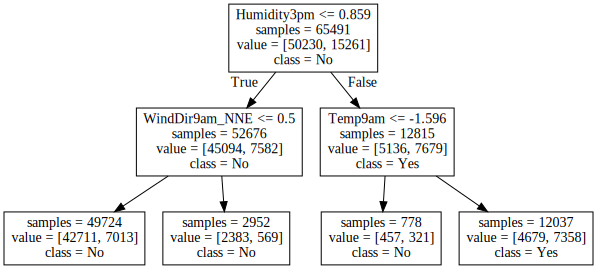

In [26]:
graphviz.Source(export_graphviz(dt, out_file=None, feature_names=new_columns,
                                class_names=dt.classes_, impurity=False))

Note: for some reason, the arrows are not labeled on the second level, but you can assume that the left side branch is always True and the right branch is always False. So, the 4 arrows in the second level should be  labelled True, False, True, False if reading from left to right.

Here is the first element of the validation set. First I print out (a subset of) the **transformed** numerical variables:

In [27]:
X_valid_transformed[numeric_features].iloc[:1,9:]

,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
1416,-1.79,-0.7,-0.88,0.19,0.16,0.89,1.71


And then I print out the **un-transformed** categorical features:

In [28]:
X_valid[categorical_features].iloc[:1]

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
1416,Albury,W,SE,W,No


## Q4

Describe the path of this example down the tree. Which of the four bottom nodes does it end up at: the 1st, 2nd, 3rd or 4th? **Maximum 3 sentences.**

<br><br><br><br><br><br><br><br><br><br><br>

---------------

The following code grabs 4 numeric features - but I'm not telling you which ones.

In [29]:
np.random.seed(1) # set random state
some_numeric_features = np.random.permutation(numeric_features)[10:14]

In hw2, for the spotify dataset, you looked at histograms of various feature values split up by target class. The following code creates 4 such histograms, one for each of the 4 randomly chosen numeric features, using the training set.

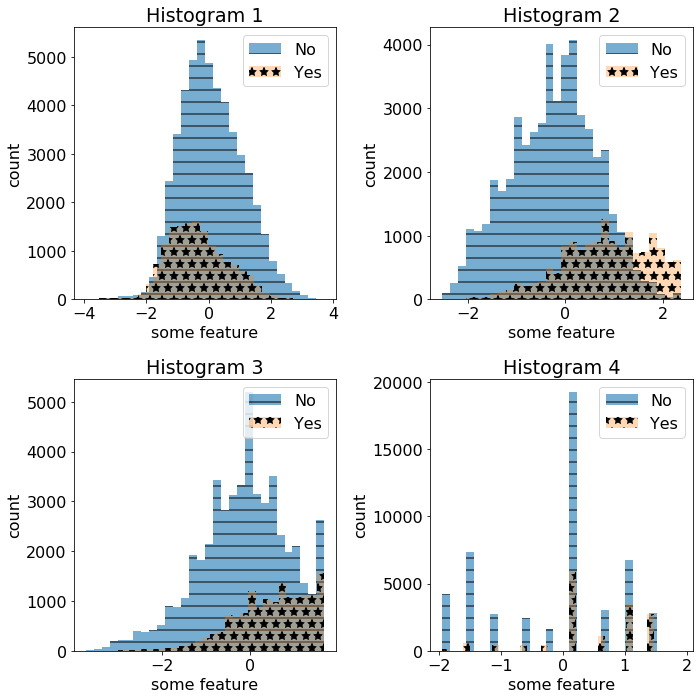

In [30]:
X_train_neg = X_train_transformed[y_train == "No"]
X_train_pos = X_train_transformed[y_train == "Yes"]

plt.figure(figsize=(10,10))
for i, feature in enumerate(some_numeric_features):

    plt.subplot(2,2,i+1)
    plt.hist(X_train_neg[feature], alpha=0.6, bins=30, label="No", hatch="-")
    plt.hist(X_train_pos[feature], alpha=0.3, bins=30, label="Yes", hatch="*")
    plt.legend(loc='upper right')
    plt.xlabel('some feature')
    plt.ylabel("count")
    plt.title(f"Histogram {i+1}")
plt.tight_layout();

## Q5

I haven't told you which feature is being used to generate each histogram. Based on the decision tree visualization above, which of the 4 histograms (Histogram 1, Histogram 2, Histogram 3, or Histogram 4) do you think corresponds to the feature `Humidity3pm`? Briefly justify your answer. **Maximum 3 sentences.**

Hint: `Humidity3pm <= 0.859` was chosen by `DecisionTreeClassifier` to be the very first split (i.e., it's at the top of the tree). This indicates that it's a useful split for separating the classes.

<br><br><br><br><br><br><br><br><br><br><br>

---------------

Next, I'll fit a logistic regression:

In [31]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_transformed, y_train);

In [32]:
lr.score(X_train_transformed, y_train)

0.8466201462796414

In [33]:
lr.score(X_valid_transformed, y_valid)

0.853887399463807

## Q6

Given the above, would it make more sense to try increasing or decreasing the `C` hyperparameter? As a reminder, increasing `C` increases model complexity. Briefly justify your answer. **Maximum 2 sentences.**

<br><br><br><br><br><br><br><br>

---------------

The following are some of the coefficients learned by `LogisticRegression` (only some of them are shown):

In [34]:
pd.DataFrame(data=lr.coef_[0], index=X_train_transformed.columns, columns=["Coefficient"])

,Coefficient
MinTemp,0.11
MaxTemp,-0.56
Rainfall,0.11
Evaporation,0.05
Sunshine,-0.33
...,...
WindDir3pm_SW,-0.05
WindDir3pm_W,0.03
WindDir3pm_WNW,0.15
WindDir3pm_WSW,-0.05


## Q7

You will notice that `Evaporation` has a positive coefficient. True or False: increasing the `Evaporation` value (and leaving all other features fixed) will increased the predicted probability that it will rain tomorrow (i.e., the positive class). Briefly justify your answer. **Maximum 2 sentences.**

<br><br><br><br><br><br><br><br>

---------------

## Q8

You will notice that `WindDir3pm_W`, which is a binary variable created by the `OneHotEncoder`, has a positive coefficient. True or False: an observation with `WindDir3pm` equal to 'W' will have a higher  predicted probability that it will rain tomorrow (i.e., the positive class) than an observation with `WindDir3pm` equal to any other value (leaving all other original features fixed). Briefly justify your answer. **Maximum 2 sentences.**

<br><br><br><br><br><br><br><br>

---------------

Next I will train a random forest on this dataset:

In [35]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train_transformed, y_train);

Here's the confusion matrix based on the **training** set:

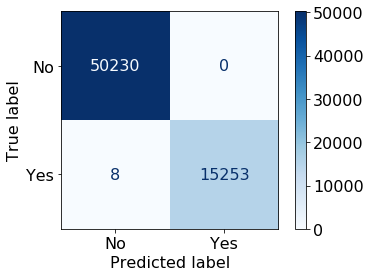

In [36]:
disp = plot_confusion_matrix(rf, X_train_transformed, y_train,
                             display_labels=rf.classes_,
                             cmap=plt.cm.Blues, 
                             values_format = 'd');

## Q9

Suppose we re-ran the code but with `class_weight="balanced"`. In that case, would you expect the number in the **lower-left** box to increase or decrease? Briefly justify your answer. **Maximum 3 sentences.**

Hint: as a reminder, `class_weight="balanced"` increases the "weight" (or importance) of examples in the minority class.

<br><br><br><br><br><br><br><br><br><br><br>

---------------

Below is the confusion matrix for the **validation** set.

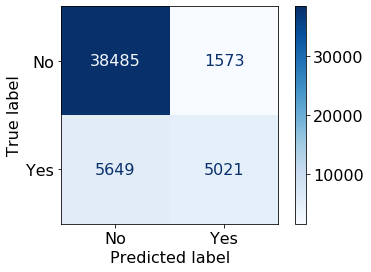

In [37]:
disp = plot_confusion_matrix(rf, X_valid_transformed, y_valid,
                             display_labels=rf.classes_,
                             cmap=plt.cm.Blues, 
                             values_format = 'd');

## Q10

Would you say this classifier is overfit? Briefly justify your answer. **Maximum 2 sentences.**

<br><br><br><br><br><br><br><br>

---------------

In scikit-learn the `RandomForestClassifier` also has a `predict_proba` method, so we can create an ROC curve. Below I do so on the **validation** set:

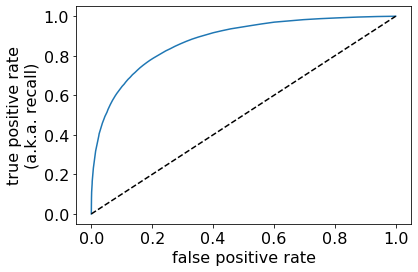

In [38]:
fpr, tpr, thresholds = roc_curve(y_valid, rf.predict_proba(X_valid_transformed)[:,1], pos_label="Yes")

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate\n(a.k.a. recall)');

## Q11

On the plot above, draw a circle to mark the point where the probability cutoff threshold is equal to 0.5. Briefly justify your answer. **Maximum 3 sentences.**

<br><br><br><br><br><br><br><br><br><br><br>

---------------

The following code grabs three classifiers learned above:
  - The `DummyClassifier` called `dc`.
  - The `LogisticRegression` called `lr`.
  - The `RandomForestClassifier` called `rf`.

In [39]:
some_models = [dc, lr, rf] 

Next, I shuffle the list of models so you don't know what order they are in.

In [40]:
np.random.seed(999)
some_models = np.random.permutation(some_models)

To remind you, here is the training accuracy in each case:

In [41]:
dc.score(X_train_transformed, y_train)

0.7669756149699959

In [42]:
lr.score(X_train_transformed, y_train)

0.8466201462796414

In [43]:
rf.score(X_train_transformed, y_train)

0.9998778458108748

In Lecture 8 we looked at some histograms of the predicted probabilities, split by the true class. The following code creates 3 such histograms for 3 different models, using the training set.

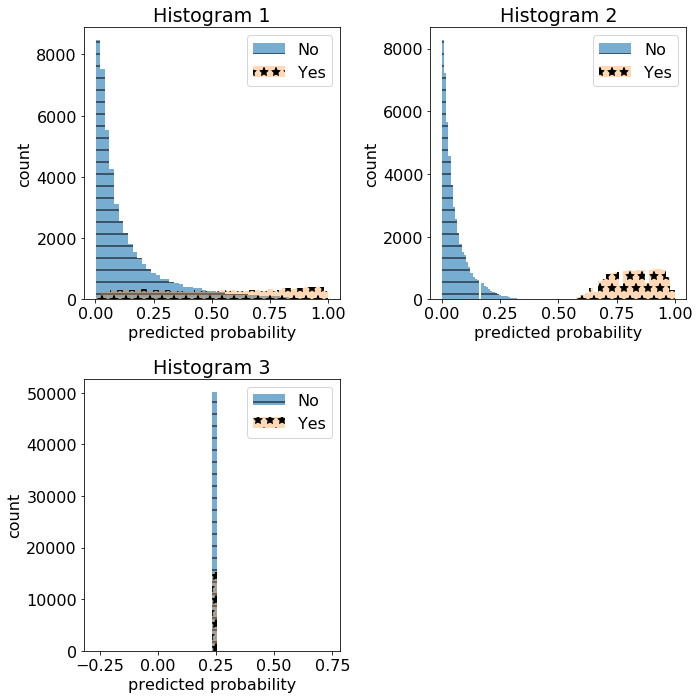

In [44]:
plt.figure(figsize=(10,10))
for i, model in enumerate(some_models):
    plt.subplot(2,2,i+1)
    plt.hist(model.predict_proba(X_train_neg)[:,1], alpha=0.6, bins=50, label="No", hatch="-")
    plt.hist(model.predict_proba(X_train_pos)[:,1], alpha=0.3, bins=50, label="Yes", hatch="*")
    plt.legend(loc='upper right')
    plt.xlabel('predicted probability')
    plt.ylabel("count")
    plt.title(f"Histogram {i+1}")
plt.tight_layout();

## Q12

I haven't told you which model is being used to generate each histogram. Which of the 3 histograms (Histogram 1, Histogram 2, or Histogram 3) do you think corresponds to the **logistic regression** (`lr`) model? Briefly justify your answer. **Maximum 3 sentences.**

<br><br><br><br><br><br><br><br><br><br><br>

---------------

Next, I want to optimize the hyperparameters of my random forest. 

In [45]:
param_grid = {
              "n_estimators"     : [10,100],
              "max_depth"        : [3, 5, 10, 15, None],
              "max_features"     : [3, None]
             }
param_grid

{'n_estimators': [10, 100],
 'max_depth': [3, 5, 10, 15, None],
 'max_features': [3, None]}

In [46]:
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid, cv=5, refit=False,
                           verbose=5, n_jobs=-1)

## Q13

For the grid search above, how many models are trained in total? Briefly justify your answer. **Maximum 2 sentences.**

Note: Don't forget to account for both the different hyperparameter values and the cross-validation folds. Also, I set `refit=False` so you don't have to account for one extra model being trained at the end.

<br><br><br><br><br><br><br><br>

---------------

At the next point of my analysis, I experience temporary insanity. I do several crazy things:

1. I set all relevant hyperparameters to 3, because 3 is a really cool number.
2. I decide to just optimize `random_state` using `GridSearchCV`, trying all integers from 0 to 999 for the `random_state`.
3. I decide to just use the first 100 training examples for my cross-validation, because I'm too impatient to wait any longer.

In [47]:
grid_search = GridSearchCV(RandomForestClassifier(n_estimators=3, max_depth=3, max_features=3), 
                           {"random_state" : list(range(1000))}, 
                           cv=3, verbose=0, n_jobs=-1)

In [48]:
grid_search.fit(X_train_transformed[:100], y_train[:100]);

Upon doing so, I get a fantastic cross-validation score:

In [49]:
grid_search.best_score_

0.9402852049910874

I will now test out this model on the test set:

In [50]:
grid_search.score(X_test_transformed, y_test)

0.6378301378301379

## Q14

Explain why the test accuracy is so much worse than the cross-validation score. **Maximum 3 sentences.**

<br><br><br><br><br><br><br><br><br><br><br>

---------------